## Stock Market Prediction Using CNN-BiLSTM and Transformer

In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 16.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Import Library for downloading(Here FB data is only shown)




In [ ]:
import yfinance as yf
df= yf.download("FB", start="2014-7-29", end="2021-12-13")

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.shape

(1858, 6)

In [ ]:
df.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-29,74.720001,74.919998,73.419998,73.709999,73.709999,41324000
2014-07-30,74.209999,75.190002,74.129997,74.680000,74.680000,36853000
2014-07-31,74.000000,74.169998,72.440002,72.650002,72.650002,43992000
2014-08-01,72.220001,73.220001,71.550003,72.360001,72.360001,43535000
2014-08-04,72.360001,73.879997,72.360001,73.510002,73.510002,30777000


#### Overview of data and plots

In [ ]:
## Making copy for future usage

df2=df.copy()

In [ ]:
df2=df2.drop(['Adj Close'],axis=1)

In [ ]:
df2

,Open,High,Low,Close,Volume
Date,,,,,
2014-07-29,74.720001,74.919998,73.419998,73.709999,41324000
2014-07-30,74.209999,75.190002,74.129997,74.680000,36853000
2014-07-31,74.000000,74.169998,72.440002,72.650002,43992000
2014-08-01,72.220001,73.220001,71.550003,72.360001,43535000
2014-08-04,72.360001,73.879997,72.360001,73.510002,30777000
...,...,...,...,...,...
2021-12-06,308.130005,320.100006,306.339996,317.869995,21758300
2021-12-07,321.570007,326.540009,321.000000,322.809998,18794000
2021-12-08,325.000000,332.750000,323.070007,330.559998,19937700


In [ ]:
df1=df.reset_index()['Adj Close']

In [ ]:
df1

0        73.709999
1        74.680000
2        72.650002
3        72.360001
4        73.510002
           ...    
1853    317.869995
1854    322.809998
1855    330.559998
1856    329.820007
1857    329.750000
Name: Adj Close, Length: 1858, dtype: float64

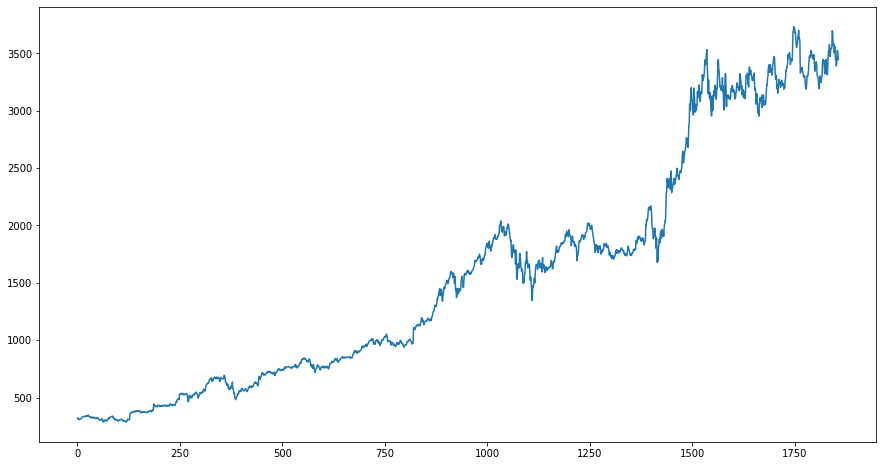

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)
plt.plot(df1)

 LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))


Train-Test split

In [ ]:
train_data, val_data, test_data = np.split(df.sample(frac=1), [int(.75*len(df)),
int(.85*len(df))])

In [ ]:
print(len(train_data),len(val_data),len(test_data))

1393 186 279


Amzn data plot with train and test split

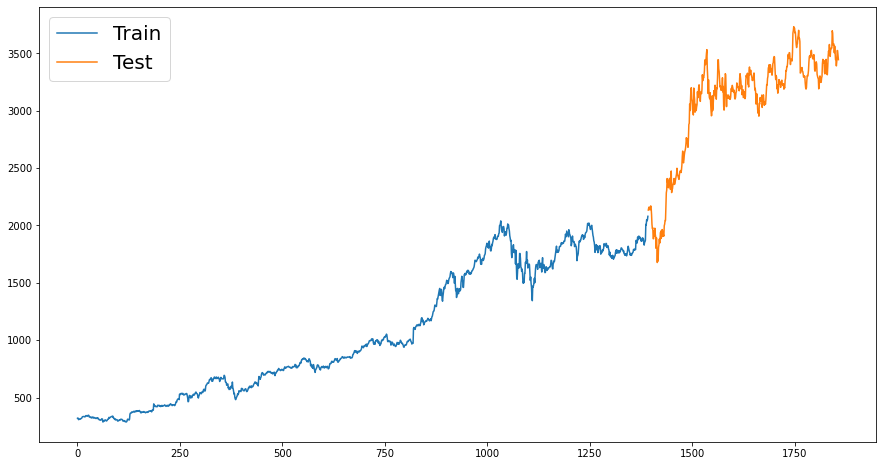

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)
plt.plot(train_data,label='Train')
plt.plot(test_data,label='Test')
plt.legend(fontsize=20)

Fb data plot with train and test split

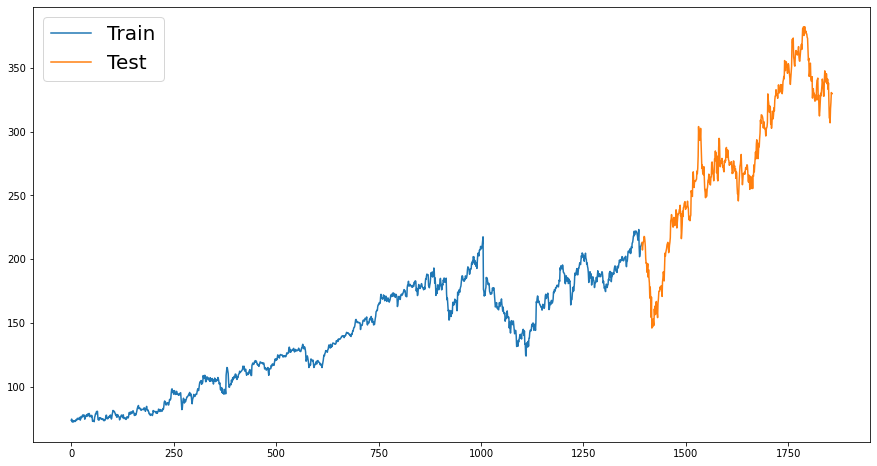

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)
plt.plot(train_data,label='Train')
plt.plot(test_data,label='Test')
plt.legend(fontsize=20)

In [ ]:
## final splitting dataset into train and test and validation split
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
val_size=int(0.1*training_size)
training_size=int(0.9*training_size)
train_data,val_data,test_data=df1[0:training_size,:],df1[training_size:training_size+val_size,:],df1[training_size+val_size:len(df1),:1]

#1252 139 464

In [ ]:
train_data.shape

(1253, 1)

In [ ]:
import numpy

# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val=create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (1152, 100) (1152,)
Validation set shape (38, 100) (38,)
Testing set shape (365, 100) (365,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val=X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.losses import mean_squared_error
from keras import backend as K

## function to calculate RMSE

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

combined architecture for BiLSTM, CNN, CNN-BiLSTM( can be altered by different models)

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Reshape, Flatten
from keras.layers import Dense, Dropout, Activation, LSTM, Convolution1D, MaxPooling1D, Flatten
from keras.layers import Bidirectional
model=Sequential()
# model.add(Conv1D(64,kernel_size=3,activation='relu',input_shape=(100,1)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(50,kernel_size=5,activation='relu'))
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(Bidirectional(LSTM(50,return_sequences=True)))
model.add(Bidirectional(LSTM(50,return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
# model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
# # model.add(LSTM(50,return_sequences=True))
# model.add(LSTM(50,return_sequences=True))
# model.add(LSTM(50))
# model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
# model.compile(loss='mse', optimizer='adam', metrics=['mae', root_mean_squared_error])


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 100)         40400     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 100)         60400     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                      

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=32,verbose=1)

Epoch 1/15
36/36 [==============================] - 21s 324ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 2/15
36/36 [==============================] - 9s 249ms/step - loss: 8.3330e-04 - val_loss: 0.0067
Epoch 3/15
36/36 [==============================] - 9s 246ms/step - loss: 5.2258e-04 - val_loss: 0.0220
Epoch 4/15
36/36 [==============================] - 9s 246ms/step - loss: 5.0563e-04 - val_loss: 0.0171
Epoch 5/15
36/36 [==============================] - 9s 246ms/step - loss: 4.4345e-04 - val_loss: 0.0108
Epoch 6/15
36/36 [==============================] - 10s 274ms/step - loss: 3.9648e-04 - val_loss: 0.0217
Epoch 7/15
36/36 [==============================] - 9s 246ms/step - loss: 3.8172e-04 - val_loss: 0.0232
Epoch 8/15
36/36 [==============================] - 9s 246ms/step - loss: 3.5098e-04 - val_loss: 0.0190
Epoch 9/15
36/36 [==============================] - 9s 248ms/step - loss: 3.6534e-04 - val_loss: 0.0149
Epoch 10/15
36/36 [==============================] - 9s 247ms/step

In [ ]:
###  prediction and check performance metrics

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
## Transformback to original form

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

These results have been performed separately

In [ ]:
### amzn bilstm mae

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_predict)

2934.1630601972342

In [ ]:
##  amzn bilstm rmse

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, test_predict))

2936.4498640127968

In [ ]:
### amzn cnn mae

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_predict)

3077.6384153716776

In [ ]:
##  amzn cnn rmse

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, test_predict))

3080.6268141047353

In [ ]:
### FB bilstm mae

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_predict)

257.0512405431462

In [ ]:
### FB cnn mae

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_predict)

289.22506507292474

In [ ]:
##  fb bilstm rmse

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, test_predict))

259.75057446948085

In [ ]:
##  fb cnn rmse

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, test_predict))

291.2722907910683

In [ ]:
### FB cnn-bilstm mae

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_predict)

242.65917833243614

In [ ]:
## cnn-bilstm fb rmse

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, test_predict))

243.82328818883047

In [ ]:
### amzn cnn-bilstm mae

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_predict)

2608.0621525292117

In [ ]:
## cnn-bilstm amzn rmse

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, test_predict))

2609.7984875329935

## Transformer model

In [ ]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd

Overview of data

In [ ]:
df= yf.download("FB", start="2014-7-29", end="2021-12-13")

print(len(df))

[*********************100%***********************]  1 of 1 completed
1858


In [ ]:
df1=df.reset_index()['Adj Close']
df1

0        73.709999
1        74.680000
2        72.650002
3        72.360001
4        73.510002
           ...    
1853    317.869995
1854    322.809998
1855    330.559998
1856    329.820007
1857    329.750000
Name: Adj Close, Length: 1858, dtype: float64

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-29,74.720001,74.919998,73.419998,73.709999,73.709999,41324000
2014-07-30,74.209999,75.190002,74.129997,74.680000,74.680000,36853000
2014-07-31,74.000000,74.169998,72.440002,72.650002,72.650002,43992000
2014-08-01,72.220001,73.220001,71.550003,72.360001,72.360001,43535000
2014-08-04,72.360001,73.879997,72.360001,73.510002,73.510002,30777000


In [ ]:
df.drop(columns=['Close'], inplace=True)
df=df.reset_index()

In [ ]:
df.drop(columns=['Date'], inplace=True)
df

,Open,High,Low,Adj Close,Volume
0,74.720001,74.919998,73.419998,73.709999,41324000
1,74.209999,75.190002,74.129997,74.680000,36853000
2,74.000000,74.169998,72.440002,72.650002,43992000
3,72.220001,73.220001,71.550003,72.360001,43535000
4,72.360001,73.879997,72.360001,73.510002,30777000
...,...,...,...,...,...
1853,308.130005,320.100006,306.339996,317.869995,21758300
1854,321.570007,326.540009,321.000000,322.809998,18794000
1855,325.000000,332.750000,323.070007,330.559998,19937700
1856,329.540009,336.130005,328.000000,329.820007,16879200


In [ ]:
train_data, val_data, test_data = np.split(df.sample(frac=1), [int(.75*len(df)),
int(.85*len(df))])

In [ ]:
print(len(train_data),len(val_data),len(test_data))

1393 186 279


In [ ]:
## splitting dataset into train and test split

training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
val_size=int(0.1*training_size)
training_size=int(0.9*training_size)

train_data,val_data,test_data=df1[0:training_size,:],df1[training_size:training_size+val_size,:],df1[training_size+val_size:len(df1),:1]
print(training_size,val_size,test_size)
#1252 139 464

1252 139 464


In [ ]:
train_data.shape

(1392, 5)

In [ ]:
train_data.shape

(1252, 1)

In [ ]:
#  Creratig Training , Test and validation data fro further processing

seq_len=100
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) 
  y_train.append(train_data.iloc[:, 3].values[i])   ### prev 4 also .iloc
X_train, y_train = np.array(X_train), np.array(y_train)


# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data.iloc[:, 3].values[i])
X_val, y_val = np.array(X_val), np.array(y_val)



# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data.iloc[:, 3].values[i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (1292, 100, 5) (1292,)
Validation set shape (85, 100, 5) (85,)
Testing set shape (179, 100, 5) (179,)


In [ ]:
## Defining hypeparameters

batch_size = 32
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
### Time2Vector layer

class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):          
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) 
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) 
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): #
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

In [ ]:
### SingleAttention Layer

class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

In [ ]:
from keras.layers import Input
import tensorflow as tf
from keras.layers import Concatenate, Dropout, LayerNormalization, Conv1D, Dense, GlobalAveragePooling1D
from keras.models import Model
from keras.losses import mean_squared_error
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

In [ ]:
#### AMZN

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))  
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  # x = Dense(64, activation='tanh')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', root_mean_squared_error])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=15, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  


## Calculate predication for training, validation and test data

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 5)]     0           []                               
                                                                                                  
 time2_vector_3 (Time2Vector)   (None, 100, 2)       400         ['input_4[0][0]']                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 100, 7)       0           ['input_4[0][0]',                
                                                                  'time2_vector_3[0][0]']         
                                                                                                  
 transformer_encoder_9 (Transfo  (None, 100, 7)      99114       ['concatenate_3[0][0]',    

performance on AMZN data

In [ ]:
### AMZN transformer mae
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_pred)

847.9947037510366

In [ ]:
##### AMZN transformer rmse
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,test_pred))

1022.5506781663163

Same code for FB data

In [ ]:
#### FB

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', root_mean_squared_error])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=15, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  


# Calculate predication for training, validation and test data

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 5)]     0           []                               
                                                                                                  
 time2_vector_7 (Time2Vector)   (None, 100, 2)       400         ['input_8[0][0]']                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 100, 7)       0           ['input_8[0][0]',                
                                                                  'time2_vector_7[0][0]']         
                                                                                                  
 transformer_encoder_21 (Transf  (None, 100, 7)      99114       ['concatenate_7[0][0]',    

performance on FB data

In [ ]:
### FB transformer  mae

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, test_pred)

59.744576779157754

In [ ]:
##### FB transformer  rmse

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,test_pred))

71.9585820542941